In [14]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
import time


from collections import defaultdict


from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [15]:
env = BlackjackEnv()

In [156]:
def make_epsilon_greedy_policy(Q, epsilon, number_of_actions):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(state):
        action_rewards = [(action, Q[(state, action)]) for action in range(number_of_actions) if (state, action) in Q] # [(action, reward), (action, reward)]

        action = int(np.round(np.random.uniform() * (number_of_actions -1))) # random action

        if np.random.uniform() < epsilon:
            print('doing random action', action)
            return action
        elif(len(action_rewards) > 0):
            # If state has happened before, get best action
            action, reward = sorted(action_rewards, key=lambda x:-x[1])[0]
            print('doing best action', action)

        return action

    return policy_fn

### TESTING
starting_state = env.reset()
print(starting_state)
q = dict()
q[( starting_state, 0)] = 0.5
q[( starting_state, 1)] = 0.1
q[( (13, 2, True), 1)] = 0.3

fn = make_epsilon_greedy_policy(q, 0.4, 2)
print(fn(starting_state))

(13, 10, False)
doing best action 0
0


In [157]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

In [158]:
def sample_episode(policy, env):
    episode = []
    state = env.reset()
    for t in range(100):
        action = policy(state)
        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state
    return episode

In [161]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    V = defaultdict(float)
    
    # Helper dictionaries for sums on all actions given a state
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    number_of_actions = 2 # Hit or strick
    Q = defaultdict(lambda: 0.0) # Q(s,a)
    N = defaultdict(float) # N(s,a)
    epsilon = 1
    pi_k = make_epsilon_greedy_policy(Q, epsilon, number_of_actions)
    
    for k in range(1, num_episodes + 1):
        episode = sample_episode(pi_k, env)
        for state, action, reward in episode:
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])

            N[(state, action)] += 1.0
            Q[(state, action)] += (1 / N[(state, action)]) * (G - Q[(state, action)])
            print(Q.values())

            returns_sum[state] += Q[(state, action)]
            returns_count[state] += N[(state, action)]
            # V[(state, action)] = Q[(state, action)] / N[(state, action)]
        
        epsilon = 1/k
        pi_k = make_epsilon_greedy_policy(Q, epsilon, number_of_actions)

    for state in returns_sum.keys():
        V[state] = returns_sum[state] / returns_count[state]

    print('average wins', ( sum(V.values()) / len(V.values())))

    return V    

In [162]:
mc_prediction(sample_policy, env, num_episodes=100,discount_factor=1)
print()

doing random action 0
dict_values([1.0])
doing random action 0
dict_values([1.0, 1.0])
doing random action 1
doing random action 0
dict_values([1.0, 1.0, -1.0])
dict_values([1.0, 1.0, -1.0, -1.0])
dict_values([1.0, 1.0, -1.0, -1.0, -1.0])
dict_values([1.0, 1.0, -1.0, -1.0, -1.0, -1.0])
doing random action 1
dict_values([1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0])
dict_values([1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0])
dict_values([1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0])
doing random action 0
dict_values([1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0])
dict_values([1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0])
dict_values([1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0])
dict_values([1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0])
dict_values([1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0])
dict_values([1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0

average wins -0.03408434606661827


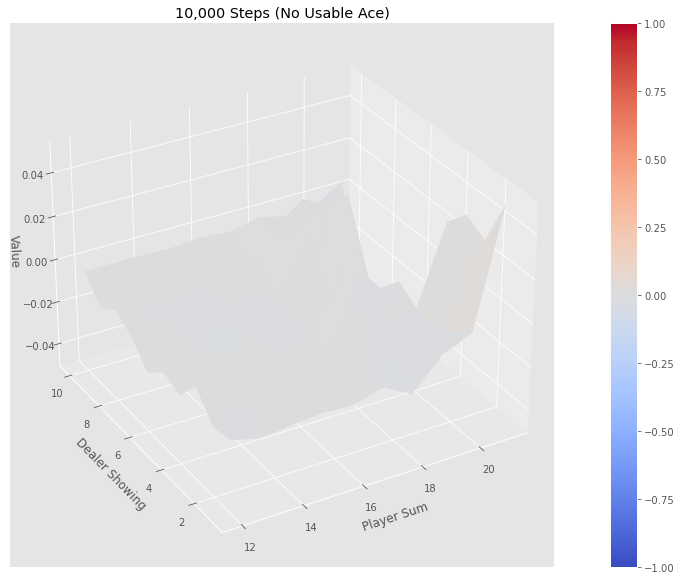

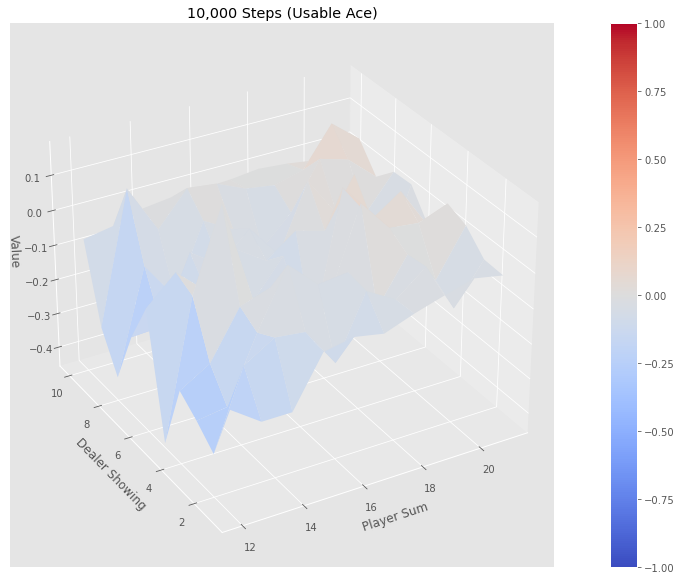


 0.8690590000000071 s
average wins -0.0005224697489097542


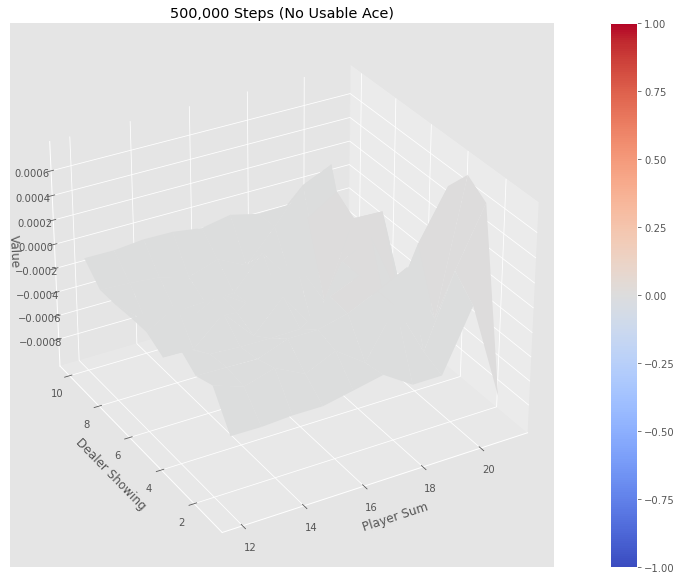

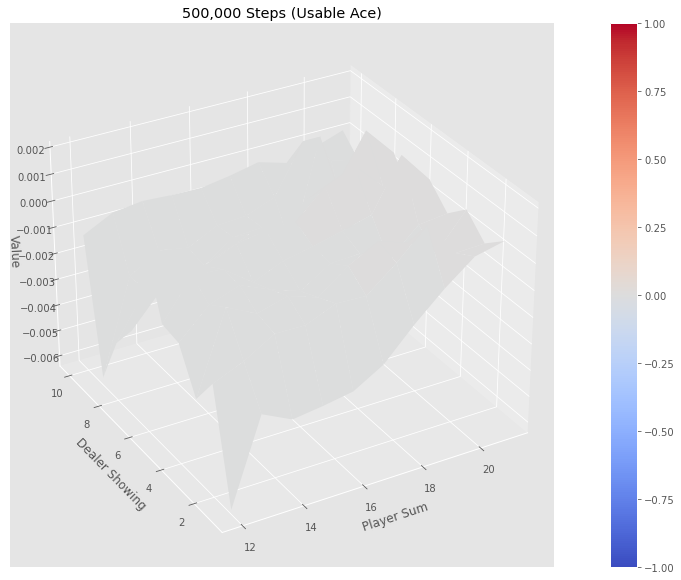


 19.525537 s


''

In [127]:
start = time.process_time() 
V_10k = mc_prediction(sample_policy, env, num_episodes=10000,discount_factor=1)
plotting.plot_value_function(V_10k, title="10,000 Steps")
end = time.process_time() 
print("\n",end - start,"s")

""
start = time.process_time() 
V_500k = mc_prediction(sample_policy, env, num_episodes=500000,discount_factor=1)
plotting.plot_value_function(V_500k, title="500,000 Steps")
end = time.process_time() 
print("\n",end - start,"s")
""